In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ufc-events-data-till-2023/ufc.csv


In [2]:
# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

In [3]:
# Load the data
ufc_df = pd.read_csv('/kaggle/input/ufc-events-data-till-2023/ufc.csv')
ufc_df.head()

,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner
0,"Austin, Texas, USA",Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punch,1.0,1:04,UFC Fight Night,2-Dec-23,Arman Tsarukyan
1,"Austin, Texas, USA",Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punches,1.0,2:49,UFC Fight Night,2-Dec-23,Jalin Turner
2,"Austin, Texas, USA",Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,Bantamweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Deiveson Figueiredo
3,"Austin, Texas, USA",Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,Welterweight,SUB Kimura,3.0,1:43,UFC Fight Night,2-Dec-23,Sean Brady
4,"Austin, Texas, USA",Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,Lightweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Joaquim Silva


In [4]:
# Get info about the Dataset
ufc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7417 entries, 0 to 7416
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       7417 non-null   object 
 1   Fighter 1      7417 non-null   object 
 2   Fighter 2      7413 non-null   object 
 3   Fighter_1_KD   7413 non-null   float64
 4   Fighter_2_KD   7413 non-null   float64
 5   Fighter_1_STR  7413 non-null   float64
 6   Fighter_2_STR  7413 non-null   float64
 7   Fighter_1_TD   7413 non-null   float64
 8   Fighter_2_TD   7413 non-null   float64
 9   Fighter_1_SUB  7413 non-null   float64
 10  Fighter_2_SUB  7413 non-null   float64
 11  Weight_Class   7413 non-null   object 
 12  Method         7413 non-null   object 
 13  Round          7413 non-null   float64
 14  Time           7413 non-null   object 
 15  Event Name     7413 non-null   object 
 16  Date           7412 non-null   object 
 17  Winner         7414 non-null   object 
dtypes: float

In [5]:
# Check missing data
ufc_df.isna().sum()

Location         0
Fighter 1        0
Fighter 2        4
Fighter_1_KD     4
Fighter_2_KD     4
Fighter_1_STR    4
Fighter_2_STR    4
Fighter_1_TD     4
Fighter_2_TD     4
Fighter_1_SUB    4
Fighter_2_SUB    4
Weight_Class     4
Method           4
Round            4
Time             4
Event Name       4
Date             5
Winner           3
dtype: int64

In [6]:
# Create a new subset with dropped missing observations
ufc_df2 = ufc_df.dropna(axis=0)
ufc_df2.isna().sum()

Location         0
Fighter 1        0
Fighter 2        0
Fighter_1_KD     0
Fighter_2_KD     0
Fighter_1_STR    0
Fighter_2_STR    0
Fighter_1_TD     0
Fighter_2_TD     0
Fighter_1_SUB    0
Fighter_2_SUB    0
Weight_Class     0
Method           0
Round            0
Time             0
Event Name       0
Date             0
Winner           0
dtype: int64

In [7]:
# Check how many observations we have left
ufc_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7412 entries, 0 to 7412
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       7412 non-null   object 
 1   Fighter 1      7412 non-null   object 
 2   Fighter 2      7412 non-null   object 
 3   Fighter_1_KD   7412 non-null   float64
 4   Fighter_2_KD   7412 non-null   float64
 5   Fighter_1_STR  7412 non-null   float64
 6   Fighter_2_STR  7412 non-null   float64
 7   Fighter_1_TD   7412 non-null   float64
 8   Fighter_2_TD   7412 non-null   float64
 9   Fighter_1_SUB  7412 non-null   float64
 10  Fighter_2_SUB  7412 non-null   float64
 11  Weight_Class   7412 non-null   object 
 12  Method         7412 non-null   object 
 13  Round          7412 non-null   float64
 14  Time           7412 non-null   object 
 15  Event Name     7412 non-null   object 
 16  Date           7412 non-null   object 
 17  Winner         7412 non-null   object 
dtypes: float64(9)

In [8]:
# Check for duplicates
ufc_df2.duplicated().sum()

0

In [9]:
# Get basic statistical description
ufc_df2.describe()

,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Round
count,7412.000000,7412.000000,7412.000000,7412.000000,7412.000000,7412.000000,7412.000000,7412.000000,7412.000000
mean,0.366972,0.063546,43.123314,28.561657,1.452105,0.666352,0.532110,0.250540,2.338505
std,0.607362,0.268197,34.396949,26.934822,1.981019,1.186660,0.939354,0.689156,1.013716
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,17.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,36.000000,22.000000,1.000000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,0.000000,61.000000,41.000000,2.000000,1.000000,1.000000,0.000000,3.000000
max,5.000000,3.000000,445.000000,271.000000,21.000000,11.000000,10.000000,7.000000,5.000000


In [10]:
# Feature engineering
# Create new dataframe with columns of interest
ufc_df3 = ufc_df2.drop(['Location','Weight_Class', 'Method', 'Round', 'Time', 'Event Name', 'Date'], axis=1)

In [11]:
# Check columns left
ufc_df3.columns

Index(['Fighter 1', 'Fighter 2', 'Fighter_1_KD', 'Fighter_2_KD',
       'Fighter_1_STR', 'Fighter_2_STR', 'Fighter_1_TD', 'Fighter_2_TD',
       'Fighter_1_SUB', 'Fighter_2_SUB', 'Winner'],
      dtype='object')

In [12]:
# Split the dataframe into 2, Fighter_1 and Fighter_2, then combine them again to use fight stats to predict match outcome
# This way we can use both sides of the data to predict wins/loses
ufc_df_F1 = ufc_df3.drop(['Fighter 2', 'Fighter_2_KD', 'Fighter_2_STR', 'Fighter_2_TD', 'Fighter_2_SUB'], axis=1)
ufc_df_F2 = ufc_df3.drop(['Fighter 1', 'Fighter_1_KD', 'Fighter_1_STR', 'Fighter_1_TD', 'Fighter_1_SUB'], axis=1)

In [13]:
# Check
print('F1:', ufc_df_F1.columns)
print('F2:', ufc_df_F2.columns)

F1: Index(['Fighter 1', 'Fighter_1_KD', 'Fighter_1_STR', 'Fighter_1_TD',
       'Fighter_1_SUB', 'Winner'],
      dtype='object')
F2: Index(['Fighter 2', 'Fighter_2_KD', 'Fighter_2_STR', 'Fighter_2_TD',
       'Fighter_2_SUB', 'Winner'],
      dtype='object')


In [14]:
# Rename the columns to make it more uniform
ufc_df_F1.rename(columns={'Fighter 1': 'Fighter_1', 'Winner': 'Win'}, inplace= True)
ufc_df_F2.rename(columns={'Fighter 2': 'Fighter_2', 'Winner': 'Win'}, inplace= True)

In [15]:
# Check
print('F1:', ufc_df_F1.columns)
print('F2:', ufc_df_F2.columns)

F1: Index(['Fighter_1', 'Fighter_1_KD', 'Fighter_1_STR', 'Fighter_1_TD',
       'Fighter_1_SUB', 'Win'],
      dtype='object')
F2: Index(['Fighter_2', 'Fighter_2_KD', 'Fighter_2_STR', 'Fighter_2_TD',
       'Fighter_2_SUB', 'Win'],
      dtype='object')


In [16]:
# Need to encode the Win column 
# If Win = Fighter then 1
ufc_df_F1['Win_enc'] = np.where(ufc_df_F1['Fighter_1'] == ufc_df_F1['Win'], '1', '0')
ufc_df_F2['Win_enc'] = np.where(ufc_df_F2['Fighter_2'] == ufc_df_F2['Win'], '1', '0')

In [17]:
# Check
ufc_df_F1.head()

,Fighter_1,Fighter_1_KD,Fighter_1_STR,Fighter_1_TD,Fighter_1_SUB,Win,Win_enc
0,Arman Tsarukyan,1.0,8.0,0.0,0.0,Arman Tsarukyan,1
1,Jalin Turner,1.0,33.0,0.0,0.0,Jalin Turner,1
2,Deiveson Figueiredo,0.0,45.0,4.0,0.0,Deiveson Figueiredo,1
3,Sean Brady,0.0,14.0,5.0,3.0,Sean Brady,1
4,Joaquim Silva,0.0,46.0,2.0,2.0,Joaquim Silva,1


In [18]:
# Check 
ufc_df_F2.head()

,Fighter_2,Fighter_2_KD,Fighter_2_STR,Fighter_2_TD,Fighter_2_SUB,Win,Win_enc
0,Beneil Dariush,0.0,2.0,0.0,0.0,Arman Tsarukyan,0
1,Bobby Green,0.0,15.0,0.0,0.0,Jalin Turner,0
2,Rob Font,0.0,46.0,0.0,0.0,Deiveson Figueiredo,0
3,Kelvin Gastelum,0.0,18.0,0.0,0.0,Sean Brady,0
4,Clay Guida,0.0,43.0,2.0,0.0,Joaquim Silva,0


In [19]:
# Also need to check if there are any typos for names of winners of original df used
ufc_df3['Contains'] = (ufc_df3['Winner'] == ufc_df3['Fighter 1']) | (ufc_df3['Winner'] == ufc_df3['Fighter 2'])
ufc_df3['Contains']

0        True
1        True
2        True
3        True
4        True
        ...  
7408    False
7409    False
7410    False
7411    False
7412    False
Name: Contains, Length: 7412, dtype: bool

In [20]:
# Unfortunately this dataset is not gonig to be usable due to the inconsitencies
# Examine the falses to see if we can continue 
ufc_df3['Contains'].value_counts()

Contains
True     7273
False     139
Name: count, dtype: int64

In [21]:
# Not too much of the data is fractured but should further be investigated under normal circumstances
# Continue by droping the False rows
# Need to backtrack and recreate the split dataframes with an updated complete dataframe
ufc_df3.drop(ufc_df3[~ufc_df3['Contains']].index, inplace=True)

In [22]:
# Check
ufc_df3.shape

(7273, 12)

In [23]:
# Remake the split groups
ufc_df_F1 = ufc_df3.drop(['Fighter 2', 'Fighter_2_KD', 'Fighter_2_STR', 'Fighter_2_TD', 'Fighter_2_SUB'], axis=1)
ufc_df_F2 = ufc_df3.drop(['Fighter 1', 'Fighter_1_KD', 'Fighter_1_STR', 'Fighter_1_TD', 'Fighter_1_SUB'], axis=1)

ufc_df_F1.rename(columns={'Fighter 1': 'Fighter_1', 'Winner': 'Win'}, inplace= True)
ufc_df_F2.rename(columns={'Fighter 2': 'Fighter_2', 'Winner': 'Win'}, inplace= True)

ufc_df_F1['Win_enc'] = np.where(ufc_df_F1['Fighter_1'] == ufc_df_F1['Win'], '1', '0')
ufc_df_F2['Win_enc'] = np.where(ufc_df_F2['Fighter_2'] == ufc_df_F2['Win'], '1', '0')

In [24]:
# Check ufc_df_F1
ufc_df_F1.head()

,Fighter_1,Fighter_1_KD,Fighter_1_STR,Fighter_1_TD,Fighter_1_SUB,Win,Contains,Win_enc
0,Arman Tsarukyan,1.0,8.0,0.0,0.0,Arman Tsarukyan,True,1
1,Jalin Turner,1.0,33.0,0.0,0.0,Jalin Turner,True,1
2,Deiveson Figueiredo,0.0,45.0,4.0,0.0,Deiveson Figueiredo,True,1
3,Sean Brady,0.0,14.0,5.0,3.0,Sean Brady,True,1
4,Joaquim Silva,0.0,46.0,2.0,2.0,Joaquim Silva,True,1


In [25]:
# Check ufc_df_F2
ufc_df_F2.head()

,Fighter_2,Fighter_2_KD,Fighter_2_STR,Fighter_2_TD,Fighter_2_SUB,Win,Contains,Win_enc
0,Beneil Dariush,0.0,2.0,0.0,0.0,Arman Tsarukyan,True,0
1,Bobby Green,0.0,15.0,0.0,0.0,Jalin Turner,True,0
2,Rob Font,0.0,46.0,0.0,0.0,Deiveson Figueiredo,True,0
3,Kelvin Gastelum,0.0,18.0,0.0,0.0,Sean Brady,True,0
4,Clay Guida,0.0,43.0,2.0,0.0,Joaquim Silva,True,0


In [26]:
# Looks good, time to combine the data, make all the column names the same in both dataframe 
ufc_df_F1.rename(columns={'Fighter_1': 'Fighter', 'Fighter_1_KD': 'KD', 'Fighter_1_STR':'STR',
                          'Fighter_1_TD': 'TD', 'Fighter_1_SUB': 'SUB'}, inplace= True)
ufc_df_F2.rename(columns={'Fighter_2': 'Fighter', 'Fighter_2_KD': 'KD', 'Fighter_2_STR':'STR',
                          'Fighter_2_TD': 'TD', 'Fighter_2_SUB': 'SUB'}, inplace= True)

In [27]:
# Check
ufc_df_F1.head()

,Fighter,KD,STR,TD,SUB,Win,Contains,Win_enc
0,Arman Tsarukyan,1.0,8.0,0.0,0.0,Arman Tsarukyan,True,1
1,Jalin Turner,1.0,33.0,0.0,0.0,Jalin Turner,True,1
2,Deiveson Figueiredo,0.0,45.0,4.0,0.0,Deiveson Figueiredo,True,1
3,Sean Brady,0.0,14.0,5.0,3.0,Sean Brady,True,1
4,Joaquim Silva,0.0,46.0,2.0,2.0,Joaquim Silva,True,1


In [28]:
# Check
ufc_df_F2.head()

,Fighter,KD,STR,TD,SUB,Win,Contains,Win_enc
0,Beneil Dariush,0.0,2.0,0.0,0.0,Arman Tsarukyan,True,0
1,Bobby Green,0.0,15.0,0.0,0.0,Jalin Turner,True,0
2,Rob Font,0.0,46.0,0.0,0.0,Deiveson Figueiredo,True,0
3,Kelvin Gastelum,0.0,18.0,0.0,0.0,Sean Brady,True,0
4,Clay Guida,0.0,43.0,2.0,0.0,Joaquim Silva,True,0


In [29]:
# Concat the dataframes
ufc_df_concat = pd.concat([ufc_df_F1, ufc_df_F2], axis= 0)
ufc_df_concat.shape

(14546, 8)

In [30]:
# Check
ufc_df_concat.head()

,Fighter,KD,STR,TD,SUB,Win,Contains,Win_enc
0,Arman Tsarukyan,1.0,8.0,0.0,0.0,Arman Tsarukyan,True,1
1,Jalin Turner,1.0,33.0,0.0,0.0,Jalin Turner,True,1
2,Deiveson Figueiredo,0.0,45.0,4.0,0.0,Deiveson Figueiredo,True,1
3,Sean Brady,0.0,14.0,5.0,3.0,Sean Brady,True,1
4,Joaquim Silva,0.0,46.0,2.0,2.0,Joaquim Silva,True,1


In [31]:
ufc_df_concat['Win_enc'].dtype

dtype('O')

In [32]:
# Drop the other columns and change Win_enc from string to int
ufc_df_concat = ufc_df_concat.drop(columns={'Win', 'Contains'}, axis= 1)
ufc_df_concat['Win_enc'] = ufc_df_concat['Win_enc'].astype(int)
ufc_df_concat.head()

,Fighter,KD,STR,TD,SUB,Win_enc
0,Arman Tsarukyan,1.0,8.0,0.0,0.0,1
1,Jalin Turner,1.0,33.0,0.0,0.0,1
2,Deiveson Figueiredo,0.0,45.0,4.0,0.0,1
3,Sean Brady,0.0,14.0,5.0,3.0,1
4,Joaquim Silva,0.0,46.0,2.0,2.0,1


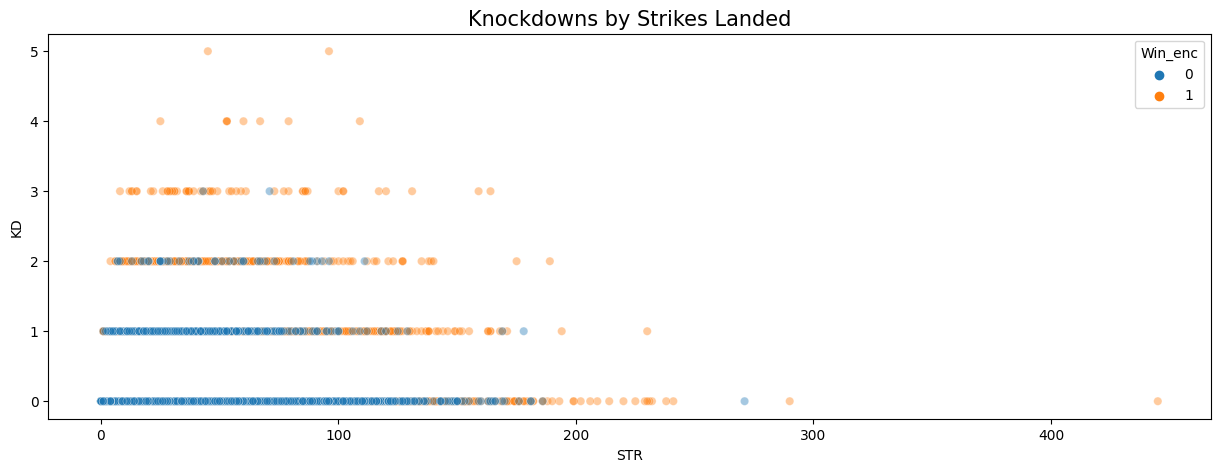

In [33]:
# Plot a visualization
plt.figure(figsize=(15,5))
sns.scatterplot(data=ufc_df_concat, x='STR', y='KD', hue='Win_enc', alpha=0.4)
plt.title('Knockdowns by Strikes Landed', fontsize='15');

In [34]:
# Check STR averages
STR_averages = ufc_df_concat['STR'].groupby(ufc_df_concat['Win_enc']).mean()
STR_averages

Win_enc
0    29.036986
1    43.749897
Name: STR, dtype: float64

In [35]:
# Check KD averages
KD_averages = ufc_df_concat['KD'].groupby(ufc_df_concat['Win_enc']).mean()
KD_averages

Win_enc
0    0.064485
1    0.372199
Name: KD, dtype: float64

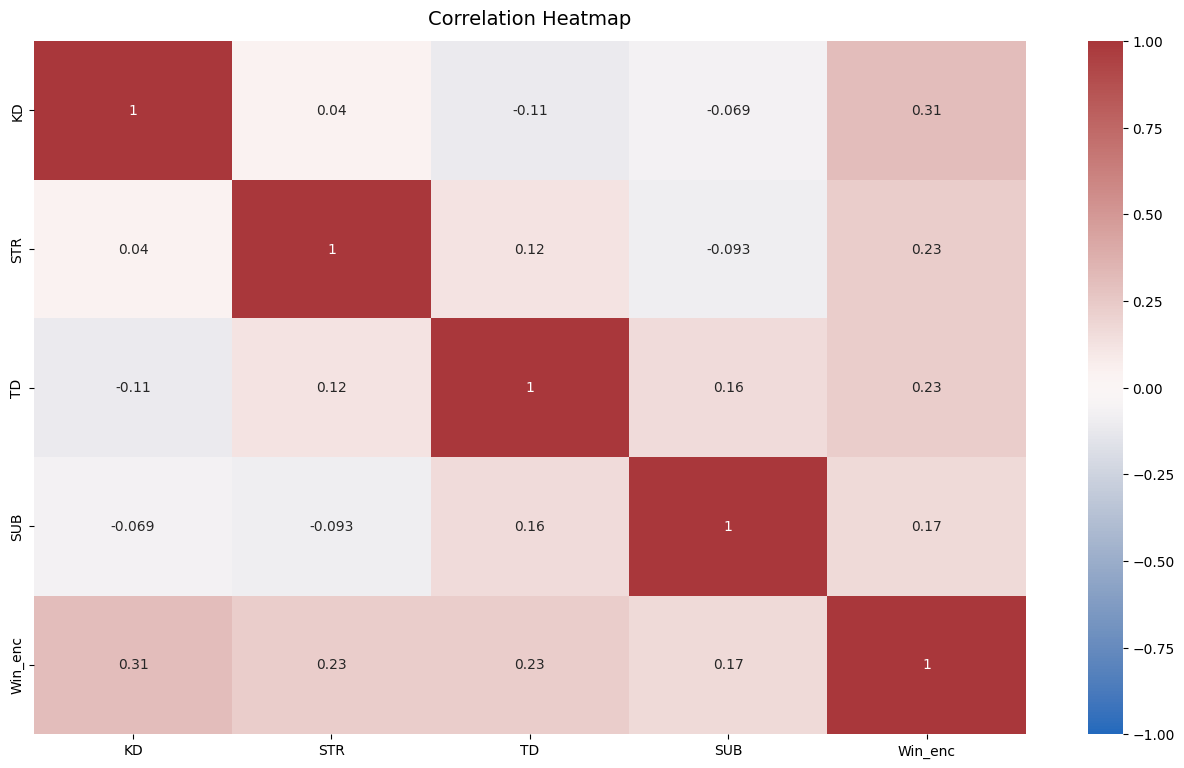

In [36]:
# heatmap to see correlation
ufc_df_concat2 = ufc_df_concat.drop(['Fighter'], axis=1)
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(ufc_df_concat2.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

In [37]:
# Check ratio of Win_enc to see if stratification is needed
ufc_df_concat2['Win_enc'].describe()

count    14546.000000
mean         0.500000
std          0.500017
min          0.000000
25%          0.000000
50%          0.500000
75%          1.000000
max          1.000000
Name: Win_enc, dtype: float64

In [38]:
# Isolate the outcome variable and create a split 
y = ufc_df_concat2['Win_enc']
X = ufc_df_concat2.drop(['Win_enc'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [39]:
# Logistic regression
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)
y_pred = log_clf.predict(X_test)

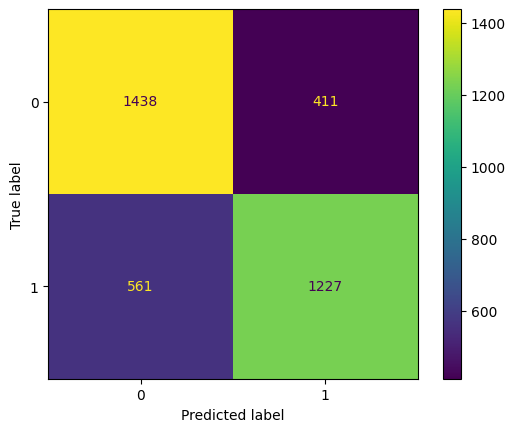

In [40]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()

In [41]:
# 1438 True negatitves, 1227 True positives
# 561 False negatives, 411 False positives 

In [42]:
# Create classification report for logistic regression model
target_names = ['Predicted would not win', 'Predicted would win']
print(classification_report(y_test, y_pred, target_names=target_names))

                         precision    recall  f1-score   support

Predicted would not win       0.72      0.78      0.75      1849
    Predicted would win       0.75      0.69      0.72      1788

               accuracy                           0.73      3637
              macro avg       0.73      0.73      0.73      3637
           weighted avg       0.73      0.73      0.73      3637



In [43]:
def make_results(model_name:str, model_object, metric:str):
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'}
    cv_results = pd.DataFrame(model_object.cv_results_)
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]})
    return table

In [44]:
# Tree based approach
# Instantiate model
rf = RandomForestClassifier(random_state=42)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [30, 50],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [45]:
%%time
rf1.fit(X_train, y_train)

CPU times: user 57 s, sys: 186 ms, total: 57.2 s
Wall time: 57.3 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [30, 50]},
             refit='roc_auc',
             scoring={'accuracy', 'precision', 'f1', 'recall', 'roc_auc'})

In [46]:
# Pickle the model
import pickle
pickle.dump(rf1, open('rf1.pk1', 'wb'))

In [47]:
# Check best AUC score on CV
rf1.best_score_

0.8304514967612959

In [48]:
# Check best params
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 50}

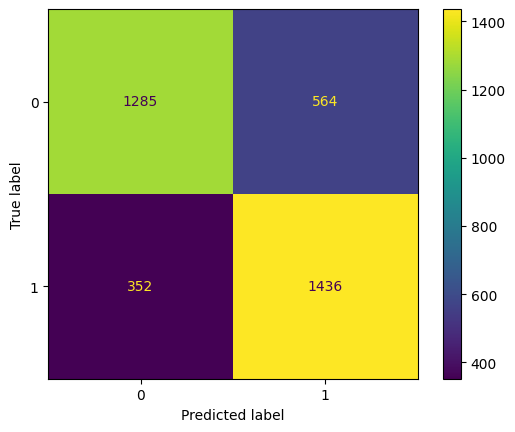

In [49]:
# Generate array of values for confusion matrix
preds = rf1.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf1.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf1.classes_)
disp.plot(values_format='');

In [50]:
# 1285 True negatitves, 1436 True positives
# 352 False negatives, 564 False positives 

# Compared to
# 1438 True negatitves, 1227 True positives
# 561 False negatives, 411 False positives 

# The randomforest model is better at predicting true positives and false negatives
# The logisticregression model is better at predicting true negatives and false positives